# RNN Implementation and Experiments

This notebook demonstrates the RNN implementation and experiments. We'll work with the NusaX-Sentiment dataset to perform text classification.

In [31]:
%load_ext autoreload
%autoreload 2

import sys
import os

sys.path.append('../..')

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Embedding, SimpleRNN, Dropout, Dense, Bidirectional
from sklearn.metrics import f1_score, classification_report

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
from src.models.src.models.base_model.utils.nusax_loader import NusaXLoader
from src.models.src.models.rnn.experiment import RNNExperiments
from src.models.src.models.rnn.rnn_model import RNNModel
from src.models.src.models.rnn.rnn_layer import RNNLayer
from src.models.src.models.base_model.layers.embedding_layer import EmbeddingLayer
from src.models.src.models.base_model.layers.dense_layer import DenseLayer
from src.models.src.models.base_model.layers.dropout_layer import DropoutLayer
from src.models.src.models.base_model.layers.activation_layer import Softmax
from src.models.src.models.base_model.utils.evaluation import compare_keras_vs_scratch
from src.models.src.models.base_model.utils.visualization import plot_training_history

In [33]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f"Num GPUs Available: {len(gpus)}")
        print(f"Num Logical GPUs: {len(logical_gpus)}")
    except RuntimeError as e:
        print(e)


Num GPUs Available: 1
Num Logical GPUs: 1


## 1. Load Data

In [34]:
# Init data loader
data_loader = NusaXLoader(batch_size=32, add=True)
# Ini add buat ngubah pathnya nambah "../" tapi harusnya gaperlu soalnya di file siblingnsnya juga gapake ini, api entah kenapa gabisa jalan kalo gadipasang

# Train
train_dataset = data_loader.get_dataset('train')
for tokens, labels in train_dataset.take(1):
    sample_tokens = tokens.numpy()
    sample_labels = labels.numpy()
    break

# Get vocabulary
vocab = data_loader.get_vocabulary()
print(f"Vocabulary size: {len(vocab)}")
print(f"First 20 words in vocabulary: {vocab[:20]}")

# Output Example
print("\nSample texts:")
for i in range(3):
    # Convert token IDs back to words
    words = [vocab[idx] if idx < len(vocab) else "[UNK]" for idx in sample_tokens[i] if idx > 0]
    text = " ".join(words)
    print(f"Text {i+1}: {text}")
    print(f"Label: {sample_labels[i]}\n")

Vocabulary size: 2836
First 20 words in vocabulary: ['', '[UNK]', np.str_('yang'), np.str_('di'), np.str_('dan'), np.str_('tidak'), np.str_('saya'), np.str_('dengan'), np.str_('enak'), np.str_('ini'), np.str_('makan'), np.str_('untuk'), np.str_('ke'), np.str_('tempat'), np.str_('makanan'), np.str_('juga'), np.str_('sangat'), np.str_('ada'), np.str_('banyak'), np.str_('karena')]

Sample texts:
Text 1: nikmati cicilan 0 hingga 12 bulan untuk pemesanan tiket pesawat air asia dengan kartu kredit bni
Label: 1

Text 2: kuekue yang disajikan bikin saya bernostalgia semuanya tipikal kue zaman dulu baik dari penampilan maupun rasa kuenya enak dan harganya juga murah
Label: 2

Text 3: ibu pernah bekerja di grab indonesia
Label: 1



## 2. Hyperparameter Experiments with RNN

In [35]:
experiments = RNNExperiments(data_loader=data_loader, batch_size=32, epochs=10, embedding_dim=100)

Vocabulary size: 2836
Number of classes: 3
Maximum sequence length: 100
Batch size: 32
Epochs: 10
Embedding dimension: 100


### 2.1 Experiment: Number of RNN Layers


=== Training model with 1 RNN Layer ===
Epoch 1/10


/root/ML/venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 0.3877 - loss: 1.0975 - val_accuracy: 0.4100 - val_loss: 1.0826
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4776 - loss: 1.0358 - val_accuracy: 0.3900 - val_loss: 1.1145
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5156 - loss: 0.9345 - val_accuracy: 0.4300 - val_loss: 1.1121
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6449 - loss: 0.8489 - val_accuracy: 0.3800 - val_loss: 1.1898
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6877 - loss: 0.7678 - val_accuracy: 0.4800 - val_loss: 1.2657
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7058 - loss: 0.7130 - val_accuracy: 0.3900 - val_loss: 1.3995
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5915 - loss: 0.9456 - val_accuracy: 0.3800 - val_loss: 1.4152
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5542 - loss: 0.9225 - val_accuracy: 0.3500 - val_loss: 1

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ (None, 100, 100)       │       283,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_11 (SimpleRNN)       │ (None, 64)             │        10,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 883,067 (3.37 MB)

 Trainable params: 294,355 (1.12 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 588,712 (2.25 MB)


=== Training model with 2 RNN Layers ===
Epoch 1/10


/root/ML/venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 203ms/step - accuracy: 0.3525 - loss: 1.1245 - val_accuracy: 0.3800 - val_loss: 1.0869
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.4156 - loss: 1.0971 - val_accuracy: 0.3200 - val_loss: 1.1740
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.4606 - loss: 1.0766 - val_accuracy: 0.3600 - val_loss: 1.2008
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.3330 - loss: 1.2984 - val_accuracy: 0.3600 - val_loss: 1.1874
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.4873 - loss: 1.0740 - val_accuracy: 0.3700 - val_loss: 1.3405
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.4370 - loss: 1.2106 - val_accuracy: 0.3600 - val_loss: 1.1281
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.3946 - loss: 1.1833 - val_accuracy: 0.3600 - val_loss: 1.2276
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.4444 - loss: 1.1182 - val_accuracy: 0.3500 - val_loss: 1

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)         │ (None, 100, 100)       │       283,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_12 (SimpleRNN)       │ (None, 100, 64)        │        10,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_13 (SimpleRNN)       │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 907,835 (3.46 MB)

 Trainable params: 302,611 (1.15 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 605,224 (2.31 MB)


=== Training model with 3 RNN Layers ===
Epoch 1/10


/root/ML/venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 237ms/step - accuracy: 0.3705 - loss: 1.2275 - val_accuracy: 0.3800 - val_loss: 1.0853
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.3938 - loss: 1.1363 - val_accuracy: 0.4100 - val_loss: 1.1433
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.3712 - loss: 1.1835 - val_accuracy: 0.3800 - val_loss: 1.1226
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.3602 - loss: 1.1714 - val_accuracy: 0.4500 - val_loss: 1.1311
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4599 - loss: 1.0479 - val_accuracy: 0.4300 - val_loss: 1.3523
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.4961 - loss: 1.1121 - val_accuracy: 0.3700 - val_loss: 1.0995
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.4125 - loss: 1.0978 - val_accuracy: 0.3300 - val_loss: 1.1661
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.3444 - loss: 1.2076 - val_accuracy: 0.3500 - val_loss: 1

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)        │ (None, 100, 100)       │       283,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_14 (SimpleRNN)       │ (None, 100, 64)        │        10,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_15 (SimpleRNN)       │ (None, 100, 64)        │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_16 (SimpleRNN)       │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 932,603 (3.56 MB)

 Trainable params: 310,867 (1.19 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 621,736 (2.37 MB)

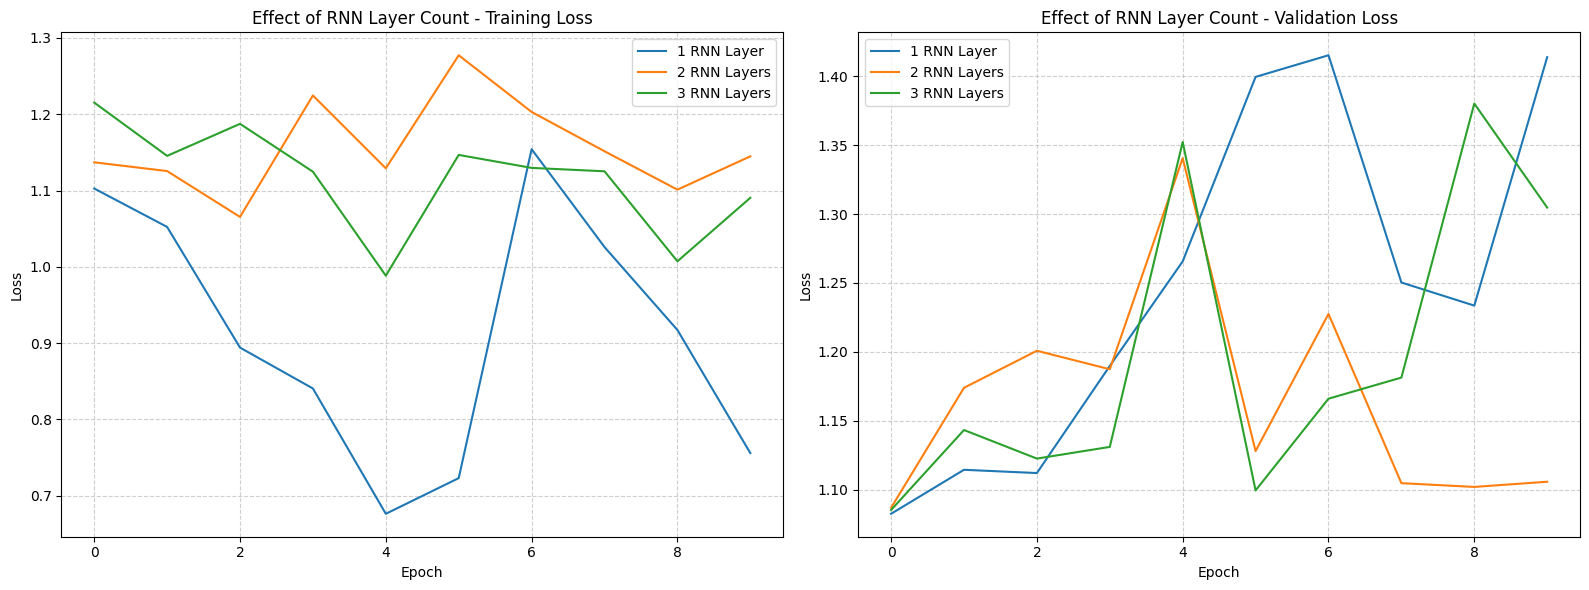

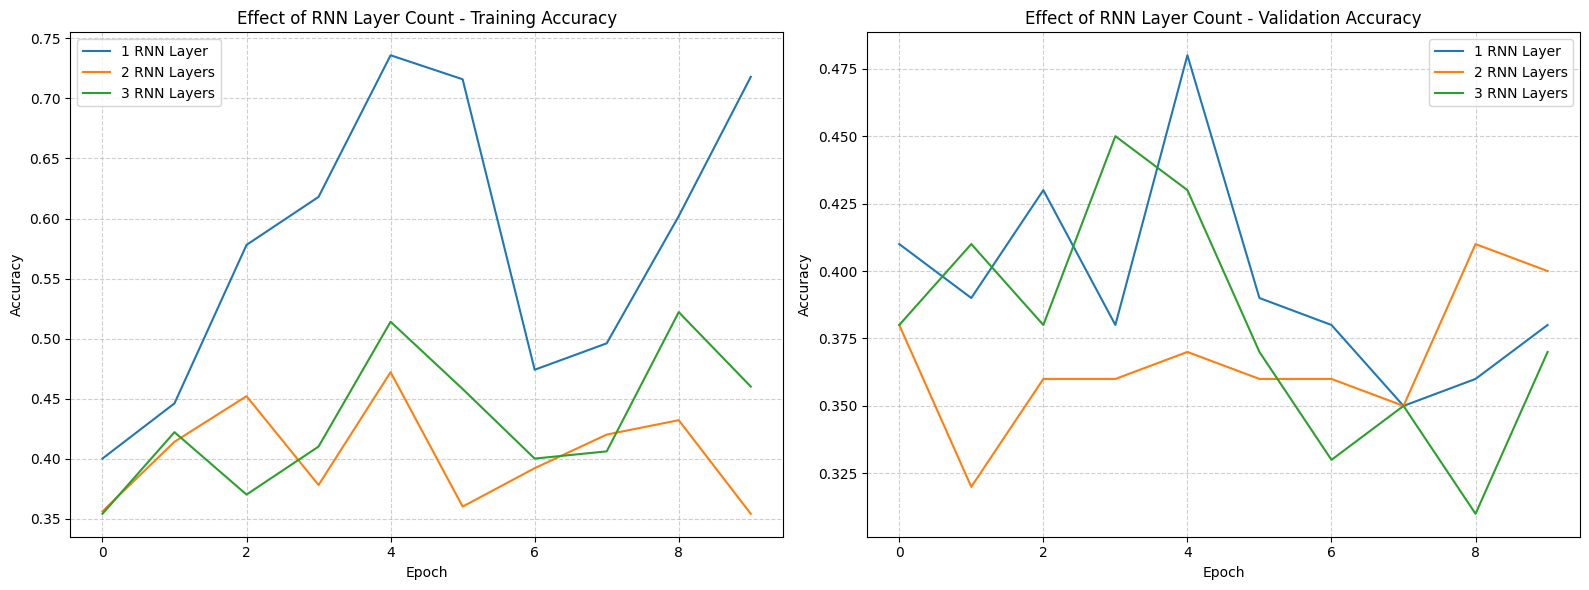

In [36]:
layer_count_variants = [
    (1, "1 RNN Layer"),
    (2, "2 RNN Layers"),
    (3, "3 RNN Layers")
]

# Run experiment
layer_count_models, layer_count_histories = experiments.run_layer_count_experiment(layer_count_variants)

### 2.2 Experiment: Number of RNN Cells per Layer


=== Training model with 32 Units ===
Epoch 1/10


/root/ML/venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 0.3598 - loss: 1.0959 - val_accuracy: 0.3800 - val_loss: 1.0794
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.4292 - loss: 1.0720 - val_accuracy: 0.3800 - val_loss: 1.1523
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2945 - loss: 1.2213 - val_accuracy: 0.5300 - val_loss: 0.9948
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6114 - loss: 0.9118 - val_accuracy: 0.5200 - val_loss: 0.9770
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7810 - loss: 0.6915 - val_accuracy: 0.6400 - val_loss: 0.8823
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8423 - loss: 0.5469 - val_accuracy: 0.5000 - val_loss: 1.0941
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7884 - loss: 0.5970 - val_accuracy: 0.3900 - val_loss: 1.3908
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5697 - loss: 0.9468 - val_accuracy: 0.2700 - val_loss: 1

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_11 (Embedding)        │ (None, 100, 100)       │       283,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_17 (SimpleRNN)       │ (None, 32)             │         4,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 863,867 (3.30 MB)

 Trainable params: 287,955 (1.10 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 575,912 (2.20 MB)


=== Training model with 64 Units ===
Epoch 1/10


/root/ML/venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 0.4043 - loss: 1.0839 - val_accuracy: 0.3800 - val_loss: 1.0823
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.4184 - loss: 1.0597 - val_accuracy: 0.3800 - val_loss: 1.1045
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5834 - loss: 0.9519 - val_accuracy: 0.4300 - val_loss: 1.1025
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7361 - loss: 0.7686 - val_accuracy: 0.3800 - val_loss: 1.1442
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9117 - loss: 0.4616 - val_accuracy: 0.3600 - val_loss: 1.3004
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9011 - loss: 0.3931 - val_accuracy: 0.3600 - val_loss: 1.3701
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9775 - loss: 0.2283 - val_accuracy: 0.4300 - val_loss: 1.2817
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9170 - loss: 0.2864 - val_accuracy: 0.3000 - val_loss: 1

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_12 (Embedding)        │ (None, 100, 100)       │       283,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_18 (SimpleRNN)       │ (None, 64)             │        10,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 883,067 (3.37 MB)

 Trainable params: 294,355 (1.12 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 588,712 (2.25 MB)


=== Training model with 128 Units ===
Epoch 1/10


/root/ML/venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 0.3973 - loss: 1.1072 - val_accuracy: 0.3800 - val_loss: 1.1115
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.3960 - loss: 1.1216 - val_accuracy: 0.3300 - val_loss: 1.2131
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3619 - loss: 1.1423 - val_accuracy: 0.3400 - val_loss: 1.1674
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.3514 - loss: 1.1561 - val_accuracy: 0.3700 - val_loss: 1.1329
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3968 - loss: 1.1119 - val_accuracy: 0.3600 - val_loss: 1.0924
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3620 - loss: 1.1364 - val_accuracy: 0.3500 - val_loss: 1.1004
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.3394 - loss: 1.1452 - val_accuracy: 0.3700 - val_loss: 1.0796
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3615 - loss: 1.1263 - val_accuracy: 0.3800 - val_loss: 1

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_13 (Embedding)        │ (None, 100, 100)       │       283,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_19 (SimpleRNN)       │ (None, 128)            │        29,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 939,899 (3.59 MB)

 Trainable params: 313,299 (1.20 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 626,600 (2.39 MB)

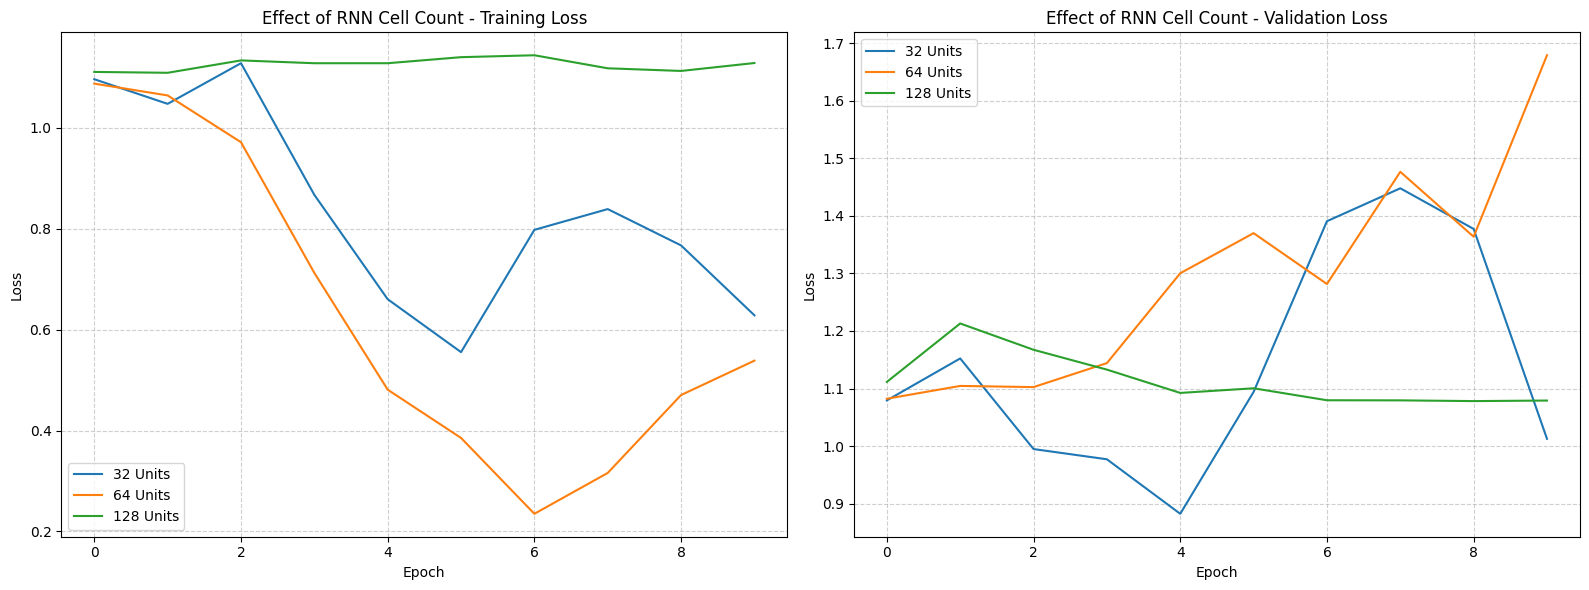

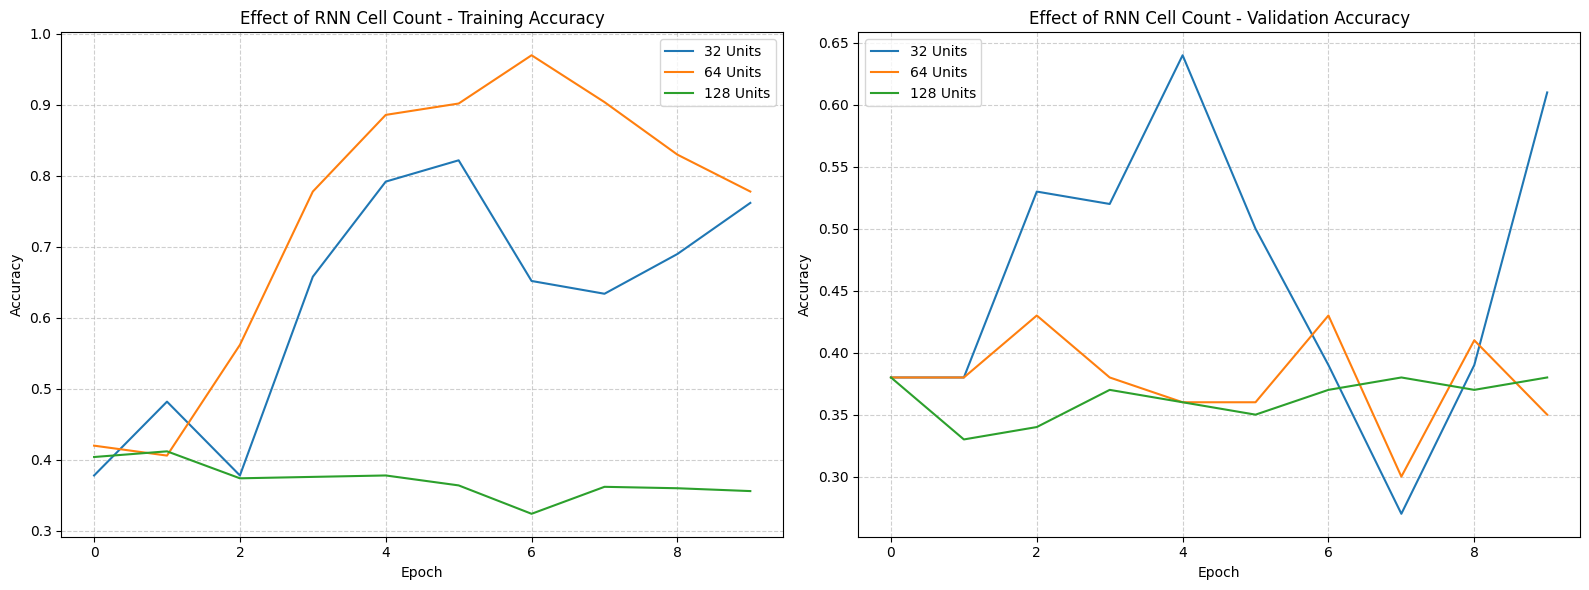

In [37]:
# Define variants for cell counts
cell_count_variants = [
    ([32], "32 Units"),
    ([64], "64 Units"),
    ([128], "128 Units")
]

# Run experiment
cell_count_models, cell_count_histories = experiments.run_cell_count_experiment(cell_count_variants)

### 2.3 Experiment: RNN Direction


=== Training model with Unidirectional RNN RNN ===
Epoch 1/10


/root/ML/venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 0.4093 - loss: 1.0925 - val_accuracy: 0.3800 - val_loss: 1.1080
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.3854 - loss: 1.1059 - val_accuracy: 0.3100 - val_loss: 1.2351
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.4398 - loss: 1.0937 - val_accuracy: 0.3600 - val_loss: 1.3086
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.3459 - loss: 1.3667 - val_accuracy: 0.3900 - val_loss: 1.1890
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.4018 - loss: 1.2000 - val_accuracy: 0.3300 - val_loss: 1.1132
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.3688 - loss: 1.1208 - val_accuracy: 0.3300 - val_loss: 1.3545
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4215 - loss: 1.2138 - val_accuracy: 0.3800 - val_loss: 1.1366
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.3854 - loss: 1.1246 - val_accuracy: 0.4200 - val_loss: 1

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_14 (Embedding)        │ (None, 100, 100)       │       283,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_20 (SimpleRNN)       │ (None, 128)            │        29,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 939,899 (3.59 MB)

 Trainable params: 313,299 (1.20 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 626,600 (2.39 MB)


=== Training model with Bidirectional RNN RNN ===
Epoch 1/10


/root/ML/venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 174ms/step - accuracy: 0.3587 - loss: 1.1102 - val_accuracy: 0.4700 - val_loss: 1.0494
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.6553 - loss: 0.8624 - val_accuracy: 0.4200 - val_loss: 1.0787
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9442 - loss: 0.4919 - val_accuracy: 0.3400 - val_loss: 1.1937
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9810 - loss: 0.2126 - val_accuracy: 0.4200 - val_loss: 1.3525
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9823 - loss: 0.0919 - val_accuracy: 0.3600 - val_loss: 1.4813
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 1.0000 - loss: 0.0394 - val_accuracy: 0.3600 - val_loss: 1.7165
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 1.0000 - loss: 0.0160 - val_accuracy: 0.2900 - val_loss: 1.7885
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9978 - loss: 0.0382 - val_accuracy: 0.4000 - val_loss: 1

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_15 (Embedding)        │ (None, 100, 100)       │       283,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 256)            │        58,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,028,987 (3.93 MB)

 Trainable params: 342,995 (1.31 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 685,992 (2.62 MB)

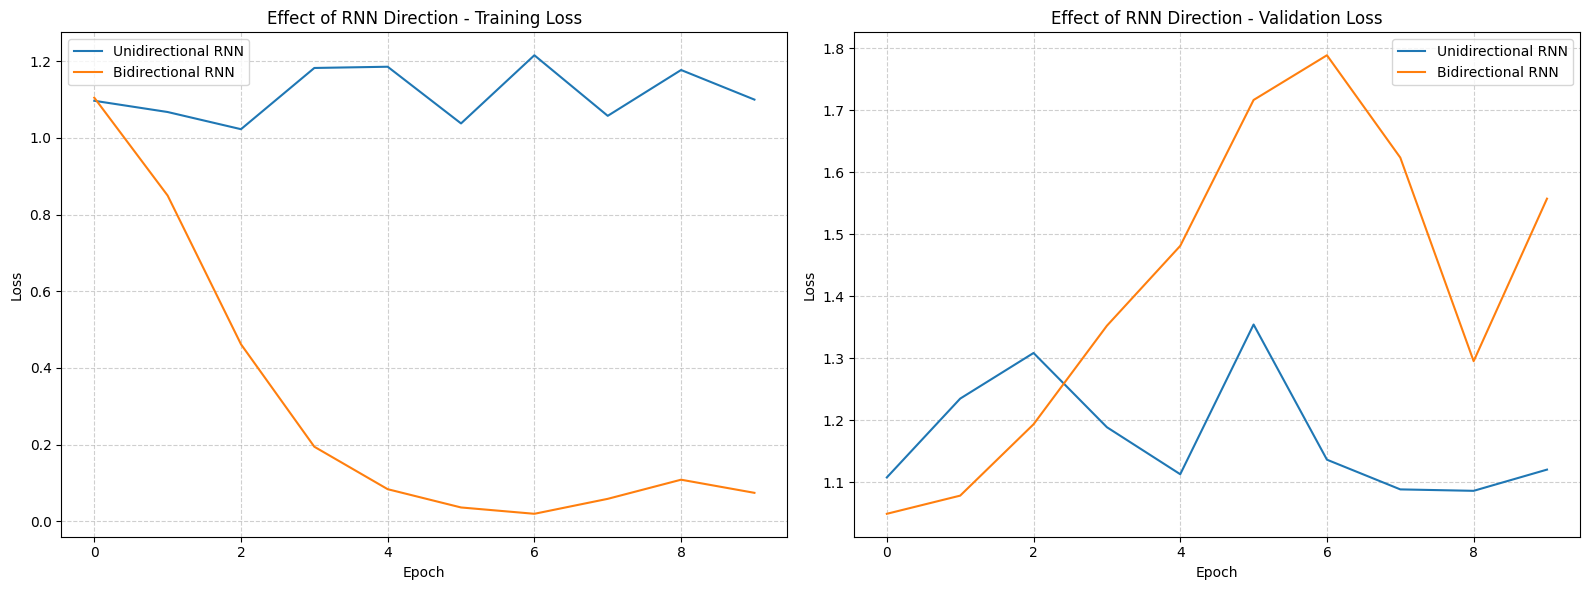

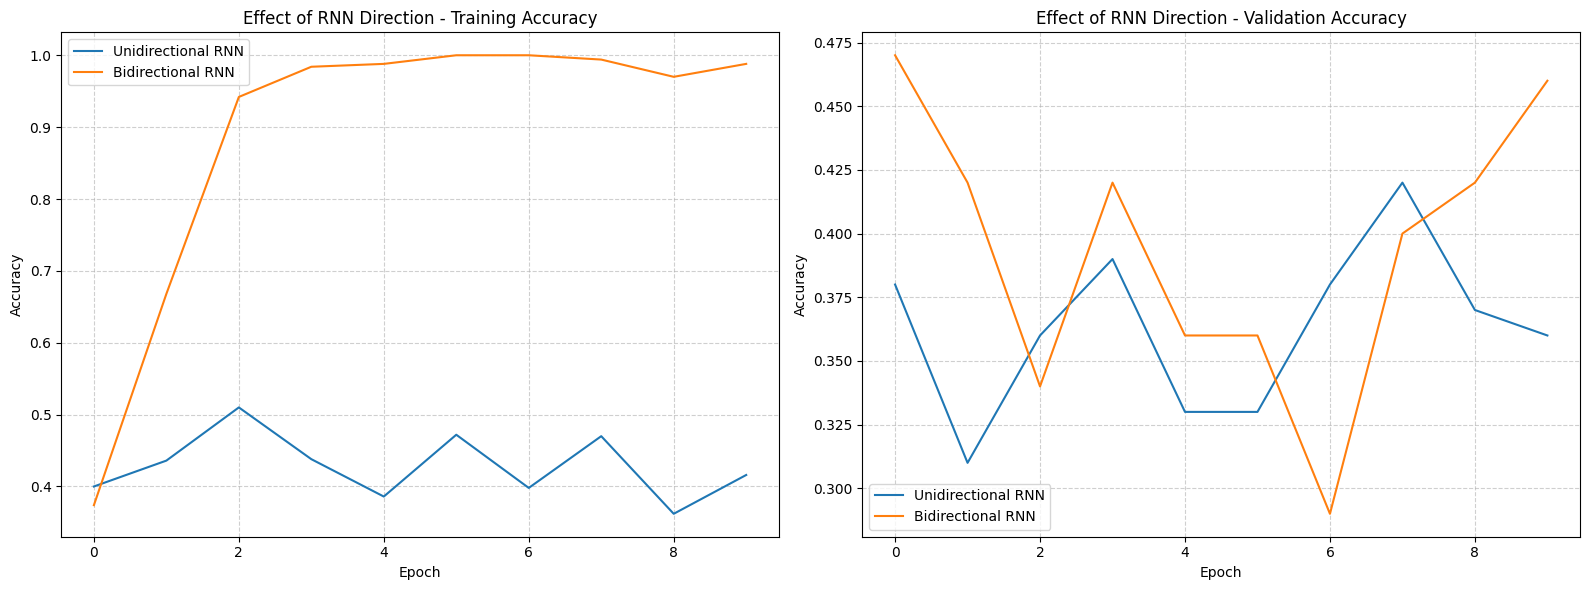

In [38]:
# Define variants for RNN direction
direction_variants = [
    (False, "Unidirectional RNN"),
    (True, "Bidirectional RNN")
]

# Run experiment
direction_models, direction_histories = experiments.run_direction_experiment(direction_variants)

## 3. From-Scratch RNN Implementation

In [39]:
keras_model_path = "../output/models/rnn/rnn_cells_32.keras"
print(experiments.compare_models(keras_model_path))


Loaded Keras model from ../output/models/rnn/rnn_cells_32.keras


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_11 (Embedding)        │ (None, 100, 100)       │       283,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_17 (SimpleRNN)       │ (None, 32)             │         4,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 863,867 (3.30 MB)

 Trainable params: 287,955 (1.10 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 575,912 (2.20 MB)

Keras model has 4 layers
Processing layer 0: Embedding
Added Embedding layer: 2836 → 100
Processing layer 1: SimpleRNN
Added RNN layer: 100 → 32 (return_sequences=False)
Processing layer 2: Dropout
Added Dropout layer: rate=0.2
Processing layer 3: Dense
Added Softmax activation

Scratch model structure:
Layer 0: EmbeddingLayer
Layer 1: RNNLayer
Layer 2: DropoutLayer
Layer 3: DenseLayer
Loading weights from Keras model...
Keras model has 4 layers
Scratch model has 4 layers

Keras model architecture:
  Layer 0: Embedding -> Unknown
  Layer 1: SimpleRNN -> Unknown
  Layer 2: Dropout -> Unknown
  Layer 3: Dense -> Unknown

Scratch model architecture:
  Layer 0: EmbeddingLayer
  Layer 1: RNNLayer
  Layer 2: DropoutLayer
  Layer 3: DenseLayer

Loading weights for layer 0:
Successfully loaded weights for layer 0

Loading weights for layer 1:
Loaded weights - W: (100, 32), U: (32, 32), b: (32,)
Successfully loaded weights for layer 1

Loading weights for layer 2:
Successfully loaded weights fo

In [43]:
keras_model_path = "../output/models/rnn/rnn_layers_3.keras"
print(experiments.compare_models(keras_model_path))


Loaded Keras model from ../output/models/rnn/rnn_layers_3.keras


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)        │ (None, 100, 100)       │       283,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_14 (SimpleRNN)       │ (None, 100, 64)        │        10,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_15 (SimpleRNN)       │ (None, 100, 64)        │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_16 (SimpleRNN)       │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 932,603 (3.56 MB)

 Trainable params: 310,867 (1.19 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 621,736 (2.37 MB)

Keras model has 8 layers
Processing layer 0: Embedding
Added Embedding layer: 2836 → 100
Processing layer 1: SimpleRNN
Added RNN layer: 100 → 64 (return_sequences=True)
Processing layer 2: Dropout
Added Dropout layer: rate=0.2
Processing layer 3: SimpleRNN
Added RNN layer: 100 → 64 (return_sequences=True)
Processing layer 4: Dropout
Added Dropout layer: rate=0.2
Processing layer 5: SimpleRNN
Added RNN layer: 100 → 64 (return_sequences=False)
Processing layer 6: Dropout
Added Dropout layer: rate=0.2
Processing layer 7: Dense
Added Softmax activation

Scratch model structure:
Layer 0: EmbeddingLayer
Layer 1: RNNLayer
Layer 2: DropoutLayer
Layer 3: RNNLayer
Layer 4: DropoutLayer
Layer 5: RNNLayer
Layer 6: DropoutLayer
Layer 7: DenseLayer
Loading weights from Keras model...
Keras model has 8 layers
Scratch model has 8 layers

Keras model architecture:
  Layer 0: Embedding -> Unknown
  Layer 1: SimpleRNN -> Unknown
  Layer 2: Dropout -> Unknown
  Layer 3: SimpleRNN -> Unknown
  Layer 4: Dro

Traceback (most recent call last):
  File "/root/ML/src/notebooks/../../src/models/src/models/rnn/experiment.py", line 406, in compare_models
    comparison = compare_keras_vs_scratch(keras_model, scratch_model, x_test, y_test, batch_size=self.batch_size)
  File "/root/ML/src/notebooks/../../src/models/src/models/base_model/utils/evaluation.py", line 20, in compare_keras_vs_scratch
    scratch_preds = scratch_model.predict(x_test)
  File "/root/ML/src/notebooks/../../src/models/src/models/rnn/rnn_model.py", line 40, in predict
    batch_outputs = self.forward(batch_inputs)
  File "/root/ML/src/notebooks/../../src/models/src/models/rnn/rnn_model.py", line 26, in forward
    raise e
  File "/root/ML/src/notebooks/../../src/models/src/models/rnn/rnn_model.py", line 20, in forward
    x = layer.forward(x)
  File "/root/ML/src/notebooks/../../src/models/src/models/rnn/rnn_layer.py", line 48, in forward
    raise ValueError(f"Input dim mismatch: expected {self.input_dim}, got {actual_input_d